## Stitcher Augmentation 

### 1. Load Image dataset

In [8]:
hyp = {'giou': 3.54,  # giou loss gain
       'cls': 37.4,  # cls loss gain
       'cls_pw': 1.0,  # cls BCELoss positive_weight
       'obj': 64.3,  # obj loss gain (*=img_size/320 if img_size != 320)
       'obj_pw': 1.0,  # obj BCELoss positive_weight
       'iou_t': 0.20,  # iou training threshold
       'lr0': 0.01,  # initial learning rate (SGD=5E-3, Adam=5E-4)
       'lrf': 0.0005,  # final learning rate (with cos scheduler)
       'momentum': 0.937,  # SGD momentum
       'weight_decay': 0.0005,  # optimizer weight decay
       'fl_gamma': 0.0,  # focal loss gamma (efficientDet default is gamma=1.5)
       'hsv_h': 0.0138,  # image HSV-Hue augmentation (fraction)
       'hsv_s': 0.678,  # image HSV-Saturation augmentation (fraction)
       'hsv_v': 0.36,  # image HSV-Value augmentation (fraction)
       'degrees': 1.98 * 0,  # image rotation (+/- deg)
       'translate': 0.05 * 0,  # image translation (+/- fraction)
       'scale': 0.05 * 0,  # image scale (+/- gain)
       'shear': 0.641 * 0}  # image shear (+/- deg)


train_path = '/store/dataset/rubbish_yolo/train.txt'
img_size = 512
batch_size = 16


from my_utils.mydatasets import *


# Dataset
dataset = LoadImagesAndLabels(train_path, img_size, batch_size,
                              augment=True,
                              hyp=hyp,  # augmentation hyperparameters
                              rect=False,  # rectangular training
                              single_cls=False)

# # Dataloader
batch_size = min(batch_size, len(dataset))
nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=batch_size,
                                         num_workers=nw,
                                         shuffle=True,  # Shuffle=True unless rectangular training is used
                                         pin_memory=True,
                                         collate_fn=dataset.collate_fn)



Caching labels (13467 found, 0 missing, 0 empty, 0 duplicate, for 13467 images): 100%|██████████| 13467/13467 [00:01<00:00, 11277.14it/s]


### 2. 测试 stitcher 操作

In [13]:
from my_utils.utils import *
import torchvision
for i, (imgs, targets, paths, _) in enumerate(dataloader):
    imgs = imgs.float() / 255.0 
    print(imgs.shape)
    plot_images(imgs, targets)
    #torchvision.utils.save_image(imgs, 'trainimg.png', nrow=4)
    
    break;

torch.Size([16, 3, 512, 512])


### 3. 显示图像和gt框

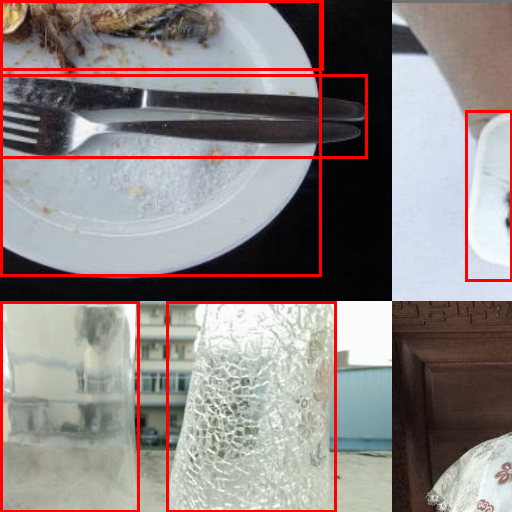

In [16]:
from PIL import Image, ImageDraw
from my_utils.utils import *
def tensor2PIL(t, m = 255):
    if m == 1:
        t = t * 255
    t = t.permute(1,2,0).numpy()
    img = Image.fromarray(t.astype(np.uint8))
    return img


"""
Param:
    image: PIL.Image
    box: array
"""
def show_box_on_image(image, boxes):
    draw = ImageDraw.Draw(image)
    for box in boxes:
        draw.rectangle(list(box), outline='red', width=3)
    del draw
    

index = 3

d = dataset[index]

img = tensor2PIL(d[0])
## xywh
boxes = d[1][:, 2:]
whwh = torch.tensor([img.size[0], img.size[1], img.size[0], img.size[1]])
boxes = xywh2xyxy(boxes) * whwh
show_box_on_image(img, boxes)

img


### 4. 测试 stitcher 数据增广 

In [ ]:
def load_image(self, index, img_size=None):
    if img_size is None:
        img_size = self.img_size
    # loads 1 image from dataset, returns img, original hw, resized hw
    img = self.imgs[index]
    if img is None:  # not cached
        path = self.img_files[index]
        img = cv2.imread(path)  # BGR
        assert img is not None, 'Image Not Found ' + path
        h0, w0 = img.shape[:2]  # orig hw
        r = img_size / max(h0, w0)  # resize image to img_size
        if r < 1 or (self.augment and r != 1):  # always resize down, only resize up if training with augmentation
        #if r !=1:
            interp = cv2.INTER_AREA if r < 1 and not self.augment else cv2.INTER_LINEAR
            img = cv2.resize(img, (int(w0 * r), int(h0 * r)), interpolation=interp)
        return img, (h0, w0), img.shape[:2]  # img, hw_original, hw_resized
    else:
        return self.imgs[index], self.img_hw0[index], self.img_hw[index]  # img, hw_original, hw_resized



## when training
def load_stitcher(self, index):
    labels4 = []
    shape = self.img_size
    indices = [index] + [random.randint(0, len(self.labels) - 1) for _ in range(3)]
    
    img4 = np.full((shape, shape, 3), 114, dtype=np.uint8)  # base image with 4 tiles
    
    for i, index in enumerate(indices):
        
        ## h0, w0 => (256x) [RESIZE]
        img, (h0, w0), (h, w) = load_image(self, index, shape // 2) ### shape // 2  => 256
        # Letterbox
        img, ratio, pad = letterbox(img, shape // 2, auto=False, scaleup=self.augment) # ratio = 1,padw + padh
        
        ## combine images
        ## top_left 0,0, 256,256 (xyxy)
        ## b_left 0,256, 256,512
        ## top_right 256,0, 512,256
        ## b_right 256, 256, 512, 512
        ### 赋值顺序
        ## 1 3
        ## 2 4
        xind = (i//2) * (shape//2), (i//2+1) * (shape//2) ## x 列 横坐标
        yind = (i%2) * (shape//2), (i%2+1) * (shape//2) ## y 行 纵坐标
        img4[yind[0]:yind[1], xind[0]:xind[1]] = img
        
        ## compute padding
        padw = pad[0] + xind[0] 
        padh = pad[1] + yind[0]
        
        ## labels
        x = self.labels[index]
        labels = x.copy()
        if x.size > 0:    
            labels[:, 1] = ratio[0] * w * (x[:, 1] - x[:, 3] / 2) + padw ## x_min
            labels[:, 2] = ratio[1] * h * (x[:, 2] - x[:, 4] / 2) + padh ## y_min
            labels[:, 3] = ratio[0] * w * (x[:, 1] + x[:, 3] / 2) + padw ## x_max
            labels[:, 4] = ratio[1] * h * (x[:, 2] + x[:, 4] / 2) + padh ## y_max
        labels4.append(labels)
        
    if len(labels4):
        labels4 = np.concatenate(labels4, 0)
    
    return img4, labels4

img, labels = load_stitcher(dataset, 1)

print(img.shape)
from PIL import Image
img = img[:,:,::-1]
img_pil = Image.fromarray(img)
print(labels)
show_box_on_image(img_pil, labels[:,1:])
img_pil

### 5. 测试 mosaic 数据增广

imgs4 shape: (1024, 1024, 3)
(512, 512, 3)


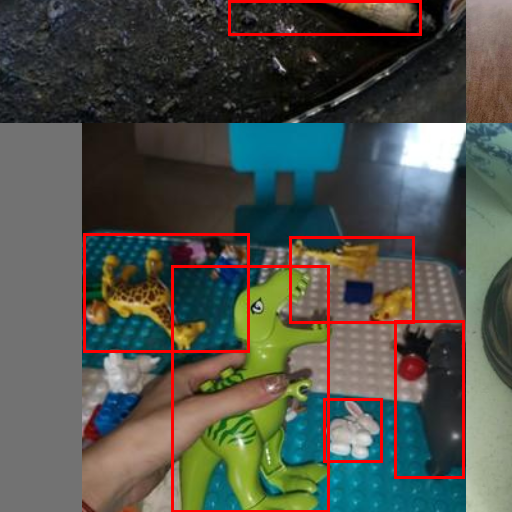

In [17]:
def load_mosaic(self, index):
    # loads images in a mosaic

    labels4 = []
    s = self.img_size
    xc, yc = [int(random.uniform(s * 0.5, s * 1.5)) for _ in range(2)]  # mosaic center x, y
    indices = [index] + [random.randint(0, len(self.labels) - 1) for _ in range(3)]  # 3 additional image indices
    for i, index in enumerate(indices):
        # Load image
        img, _, (h, w) = load_image(self, index)

        # place img in img4
        if i == 0:  # top left
            img4 = np.full((s * 2, s * 2, img.shape[2]), 114, dtype=np.uint8)  # base image with 4 tiles
            print('imgs4 shape:', img4.shape)
            x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
            x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
        elif i == 1:  # top right
            x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
            x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
        elif i == 2:  # bottom left
            x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
            x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
        elif i == 3:  # bottom right
            x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
            x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)

        img4[y1a:y2a, x1a:x2a] = img[y1b:y2b, x1b:x2b]  # img4[ymin:ymax, xmin:xmax]
        padw = x1a - x1b
        padh = y1a - y1b

        # Labels
        x = self.labels[index]
        labels = x.copy()
        if x.size > 0:  # Normalized xywh to pixel xyxy format
            labels[:, 1] = w * (x[:, 1] - x[:, 3] / 2) + padw
            labels[:, 2] = h * (x[:, 2] - x[:, 4] / 2) + padh
            labels[:, 3] = w * (x[:, 1] + x[:, 3] / 2) + padw
            labels[:, 4] = h * (x[:, 2] + x[:, 4] / 2) + padh
        labels4.append(labels)

    # Concat/clip labels
    if len(labels4):
        labels4 = np.concatenate(labels4, 0)
        # np.clip(labels4[:, 1:] - s / 2, 0, s, out=labels4[:, 1:])  # use with center crop
        np.clip(labels4[:, 1:], 0, 2 * s, out=labels4[:, 1:])  # use with random_affine


    # Augment
    # img4 = img4[s // 2: int(s * 1.5), s // 2:int(s * 1.5)]  # center crop (WARNING, requires box pruning)
    img4, labels4 = random_affine(img4, labels4,
                                  degrees=self.hyp['degrees'],
                                  translate=self.hyp['translate'],
                                  scale=self.hyp['scale'],
                                  shear=self.hyp['shear'],
                                  border=-s // 2)  # border to remove

    return img4, labels4

img, labels = load_mosaic(dataset, 1)

print(img.shape)
from PIL import Image
img = img[:,:,::-1]
img_pil = Image.fromarray(img)
#print(labels)
show_box_on_image(img_pil, labels[:,1:])
img_pil

## Copy-Paste Augmentation

stitcher 和 mosaic 的数据增广方式，会使得数据中包含足够多的小样本，
所以不再需要这类增加小样本个数的数据增广